In [1]:
from network import Generator, Discriminator, weight_init
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from DataLoading import mnistLoader
import os
from torch.utils.tensorboard import SummaryWriter

In [2]:
BATCH_SIZE = 16


In [3]:

data_loader = mnistLoader()
train_loader, _ = data_loader.train_val_loader(BATCH_SIZE, BATCH_SIZE, shuffle=True, split = 0.9, ratio = 0.5)

In [4]:
def visualize(x):

    x = x.clone().detach()
    fig = plt.figure(figsize=(10,7))
    for i in range(x.shape[0]):
        fig.add_subplot(4,int(x.shape[0]/4), i+1)
        image = torch.squeeze(x[i]).numpy() 
        plt.imshow(image)
        plt.axis('off')

    plt.show()

In [5]:
nzd, ngf, ndf = 64, 64, 64

test_set = torch.randn(BATCH_SIZE, nzd, 1, 1)

In [6]:
GAN_name = 'amir-model'

netD = Discriminator(1, ndf)
netG = Generator(nzd, ngf, 1)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
netD.to(device)
netG.to(device)

netD.apply(weight_init)
netG.apply(weight_init)
loss_fn = nn.BCELoss()
optimizerG = optim.Adam(netG.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr =0.001,  betas=(0.5, 0.999))

num_epochs = 1
G_losses = []
D_losses = []


In [7]:

writerD = SummaryWriter('logs/' + '/Discriminator')
writerG = SummaryWriter('logs/' + '/Generator')
iteration = 0

In [8]:
def save_checkpoint(model_state_dict, optimizer_state_dict, iteration, loss, name):
        checkpoint = {
            'iteration' : iteration,
            'model_state' : model_state_dict,
            'optimizer_state' : optimizer_state_dict,
            'loss' : loss,
            'name' : name
        }
        path = 'checkpoints/'
        if not os.path.exists(path):
            os.mkdir(path)
        path = path + name + '/'
        if not os.path.exists(path):
            os.mkdir(path) 
        new_path = ''
        for i in range(1000):
            new_path = path + 'checkpoint_'+ str(i) + '.pt'
            if not os.path.exists(new_path):
                torch.save(checkpoint, new_path)
                break
        print('*************************************************************')
        print(f'Checkpoint: {name}:[ iteration: {iteration+1}, loss: {loss:.3f} \nsaved on {new_path}]')
        print('*************************************************************')

        
        
        
        

epoch: 0, iter: 0, Loss_D: 1.5216978788375854, Loss_G: 0.0003531566762831062, test_set: 0.46601444482803345


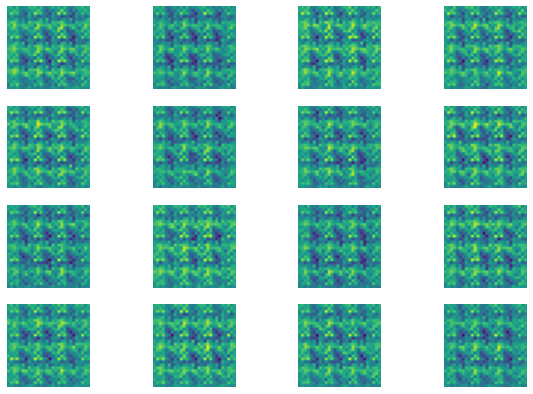

epoch: 0, iter: 50, Loss_D: 2.524380397517234e-05, Loss_G: 3.725290653733282e-08, test_set: 4.2955662138410844e-07


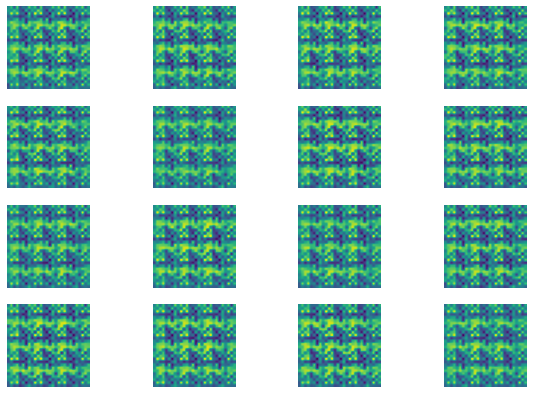

epoch: 0, iter: 100, Loss_D: 1.0766112836790853e-06, Loss_G: 0.0, test_set: 6.79161686889529e-08


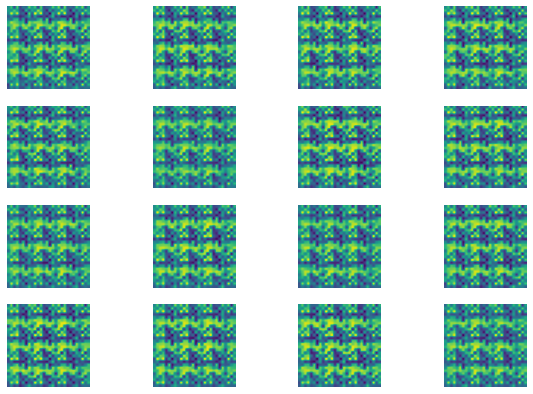

epoch: 0, iter: 150, Loss_D: 3.4310833143536e-06, Loss_G: 0.0, test_set: 5.8057771923358814e-08


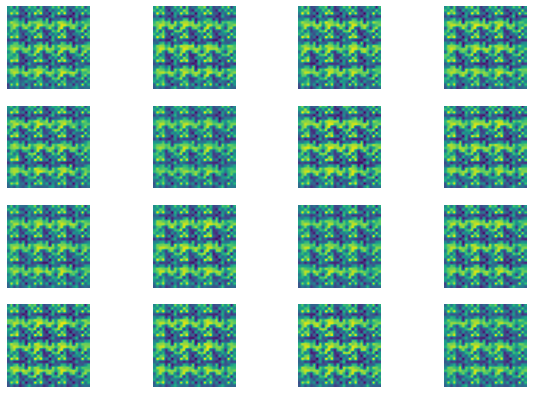

*************************************************************
Checkpoint: Generator:[ iteration: 201, loss: 0.000 
saved on checkpoints/Generator/checkpoint_1.pt]
*************************************************************
*************************************************************
Checkpoint: Discriminator:[ iteration: 201, loss: 0.000 
saved on checkpoints/Discriminator/checkpoint_1.pt]
*************************************************************
epoch: 0, iter: 200, Loss_D: 5.587949090113398e-07, Loss_G: 0.0, test_set: 5.0597861900314456e-08


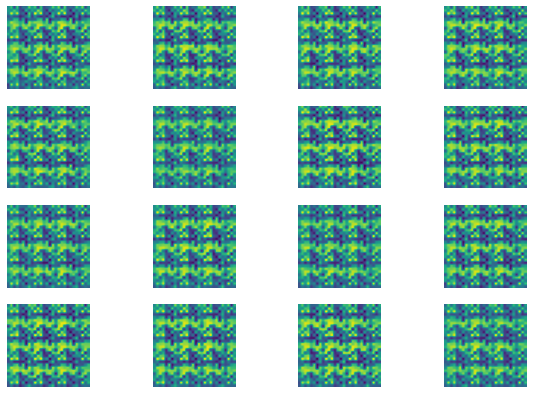

epoch: 0, iter: 250, Loss_D: 5.587936158235607e-08, Loss_G: 0.0, test_set: 3.813544680042469e-08


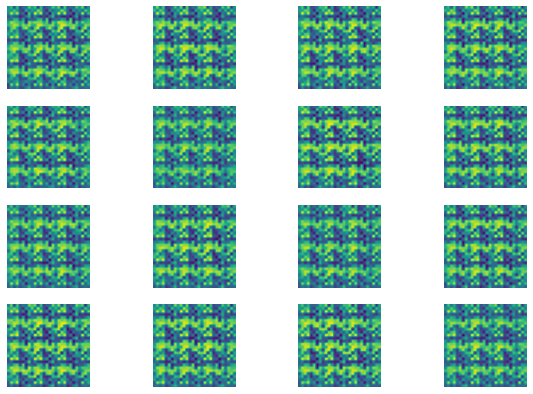

epoch: 0, iter: 300, Loss_D: 2.42144039930281e-07, Loss_G: 0.0, test_set: 3.751509325411462e-08


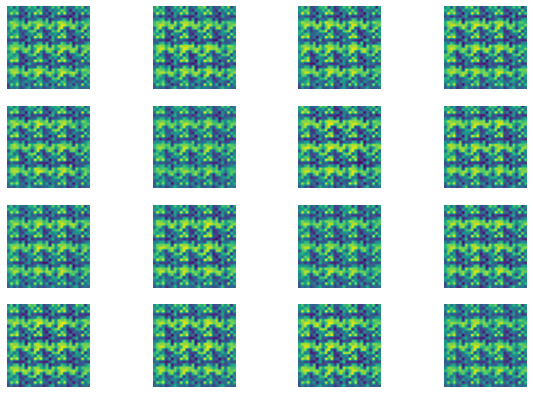

KeyboardInterrupt: 

In [9]:
max_iteration = 1000
for epoch in range(num_epochs):
    if iteration > 1000:
        break
    for i, data in enumerate(train_loader, 0):
        if(iteration > 1000):
            break
        iteration += 1
        real_img, _ = data
        netD.zero_grad()
        output_real = netD(real_img)

        fake_labels = torch.zeros(BATCH_SIZE)
        real_labels = torch.ones(real_img.shape[0])

        errD_real = loss_fn(output_real, real_labels)
        errD_real.backward()

        D_x = output_real.mean().item()


        noise = torch.randn(BATCH_SIZE, nzd, 1, 1)
        fake_img = netG(noise)
        output_fake = netD(fake_img.detach())
        errD_fake = loss_fn(output_fake, fake_labels)

        D_G_z1 = output_fake.mean().item()

        errD_fake.backward()
        errD = errD_fake + errD_real
        optimizerD.step()

        ###############################

        netG.zero_grad()
        output_fake = netD(fake_img)
        errG = loss_fn(output_fake, real_labels)

        D_G_z2 = output_fake.mean().item()
        errG.backward()
        optimizerG.step()

        ###############################
        
        writerD.add_scalar('loss',errD.item() , iteration)
        writerG.add_scalar('loss',errG.item() , iteration)

        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if i%50 == 0:
            netG.eval()
            netD.eval()
            with torch.no_grad():
                img_fake = netG(test_set)
                output_fake = netD(img_fake).mean().item()
                print(f'epoch: {epoch}, iter: {i}, Loss_D: {errD.item():.4f}, Loss_G: {errG.item():.4f}, test_set: {output_fake}')
                visualize(img_fake)
            
            
            netG.train()
            netD.train()
        if i%200 == 199:
            save_checkpoint(netG.state_dict(), optimizerG.state_dict(), iteration, errG.item(), 'Generator')
            save_checkpoint(netD.state_dict(), optimizerD.state_dict(), iteration, errD.item(), 'Discriminator')
    





In [ ]:

path = 'saved-models/'
if not os.path.exists(path):
    os.mkdir(path)
PATH = ''
for i in range(1000):
    PATH = path + GAN_name + '_' + str(i) + '.pt' 
    if not os.path.exists(PATH):
        break

torch.save({
    'Generator' : netG.state_dict(),
    'Discriminator' : netD.state_dict(),
    'optimizerG' : optimizerG.state_dict(),
    'optimizerD' : optimizerD.state_dict()
}, PATH)

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()